In [1]:
""" (WGAN GP)
Wasserstein GAN with Gradient Penalties ('improved methods for WGAN training')

https://arxiv.org/pdf/1704.00028.pdf

Proposes a gradient penalty to add to the discriminator loss as an alternative method for
enforcing the Lipschitz constraint. This penalty does not suffer from the biasing
of the discriminator toward simple funtions due to weight clipping. Additionally, the
reformulation of the discriminator in this way makes batch normalization not necessary. This
is notable because batch normalization implicitly changes the discriminator's problem from
mapping one-to-one to many-to-many.

"""
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from itertools import product
from load_data import get_data

def to_var(x):
    """ function to automatically cudarize.. """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Load in data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

In [12]:
class Generator(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        """ Generator. Input is noise, output is a generated image. """
        super(Generator, self).__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation
        
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_dim, output_dim):
        """ Discriminator / Critic (not trained to classify). Input is an image (real or generated), output is P(generated). """
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.relu(self.discriminate(activated))
        return discrimination
    
class WGANGP(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim, output_dim = 1):
        """ Super class to contain both Discriminator (D) and Generator (G) """
        super(WGANGP, self).__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim
    
class Trainer:
    def __init__(self, train_iter, val_iter, test_iter):
        """ Object to hold data iterators, train a GAN variant """
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
    
    def train(self, model, num_epochs, G_lr = 5e-4, D_lr = 5e-4, D_steps = 5):
        """ Train a Wasserstein GAN with Gradient Penalty
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            model: initialized GAN module instance
            num_epochs: int, number of epochs to train for
            G_lr: learning rate for generator's Adam optimizer (default 1e-4)
            D_lr: learning rate for discriminator's Adam optimizer (default 1e-4)
            D_steps: training step ratio for how often to train D compared to G (default 5)
        Outputs:
            model: trained WGANGP instance """
        G_optimizer = torch.optim.RMSprop(params=[p for p in model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.RMSprop(params=[p for p in model.D.parameters() if p.requires_grad], lr=D_lr)
        
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        for epoch in tqdm_notebook(range(1, num_epochs + 1)):
            model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                # TRAINING D: Train D for D_steps 
                for _ in range(D_steps):
                    
                    # Retrieve batch
                    images = self.process_batch(self.train_iter)

                    # Zero out gradients for D
                    D_optimizer.zero_grad()

                    # Train the discriminator using samples from the generator
                    D_loss = self.train_D_step(model, images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Save relevant output for progress logging, clamp weights
                    D_step_loss.append(D_loss)
                                                        
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries.
                D_losses.append(np.mean(D_step_loss))
                
                # TRAINING G: Zero out gradients for G. 
                G_optimizer.zero_grad()

                # Sample from the generator, reclassify using discriminator to train generator. Keep same batch as
                # the last step for training D
                DG_score = self.train_G_step(model, images)

                # Train the generator using predictions from D on the noise compared to true image labels
                # (learn to generate examples from noise that fool the discriminator)
                G_loss = -(torch.mean(DG_score))

                # Update parameters
                G_loss.backward()
                G_optimizer.step()

                # Save relevant output for progress logging
                G_losses.append(G_loss)
                
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses)))
            
            # Visualize generator progress
            fig = self.generate_images(model, epoch)
            plt.show()
            
        return model
    
    def train_D_step(self, model, images, LAMBDA = 10):
        """ Run 1 step of training for discriminator
            
            G_noise = randomly generated noise, x'
            G_output = G(x'), generated images from noise
            DX_score = D(x), probability x is generated where x are real images
            DG_score = D(G(x')), probability G(x') is a generation where x' is noise
        """      
        
        # ORIGINAL CRITIC:
        # Sample noise, an output from the generator
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = model.G(noise)
        
        # Use the discriminator to sample real, generated images
        DX_score = model.D(images) # D(x), "real"
        DG_score = model.D(G_output) # D(G(x')), "fake"
        
        # GRADIENT PENALTY:
        # Uniformly sample along one straight line per each batch entry. 
        epsilon = torch.rand(images.shape[0], 1).expand(images.size())

        # Generate images from the noise, ensure unit gradient norm 1 (compared to TensorFlow original implementation this is foiled out)
        # See Section 4 and Algorithm 1 of original paper for full explanation.
        G_interpolation = to_var(epsilon*images.data + ((1-epsilon)*G_output.data)) # negation doesn't matter; we square later on
        G_interpolation.requires_grad = True

        D_interpolation = model.D(G_interpolation)

        # Compute the gradients of D with respect to the noise generated input
        gradients = torch.autograd.grad(outputs = D_interpolation, 
                            inputs = G_interpolation,
                            grad_outputs = torch.ones(D_interpolation.size()), # TODO: cuda
                            only_inputs = True,
                            create_graph = True,
                            retain_graph = True,)[0]

        # Full gradient penalty
        grad_penalty = LAMBDA * torch.mean((gradients.norm(2, dim = 1) - 1) **2)
        
        D_loss = torch.mean(DG_score) - torch.mean(DX_score) + grad_penalty
        
        return D_loss
    
    def train_G_step(self, model, images):
        """ Run 1 step of training for generator
        
            G_noise = randomly generated noise, x'
            G_output = G(x')
            DG_score = D(G(x'))
        """
        G_noise = self.compute_noise(images.shape[0], model.z_dim) # x'
        G_output = model.G(G_noise) # G(x')
        DG_score = model.D(G_output) # D(G(x'))
        
        G_loss = -(torch.mean(DG_score))
        return DG_score
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_var(torch.randn(batch_size, z_dim))
    
    def generate_images(self, model, epoch, num_outputs = 25, save = True):
        """ Visualize progress of generator learning """
        noise = self.compute_noise(num_outputs, model.z_dim)
        images = model.G(noise)
        images = images.view(images.shape[0], 28, 28)
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        if save:
            if not os.path.exists('../viz/wgp-gan/'):
                os.makedirs('../viz/wgp-gan/')
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), '../viz/wgp-gan/reconst_%d.png' %(epoch), nrow = 5)
        return fig
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_var(images.view(images.shape[0], -1))
        return images

    def save_model(self, model, savepath):
        """ Save model state dictionary """
        torch.save(model.state_dict(), savepath + 'saved_gan.pth')
    
    def load_model(self, loadpath,  model = None):
        """ Load state dictionary into model. If model not specified, instantiate it """
        if not model:
            model = WGANGP()
        state = torch.load(loadpath)
        model.load_state_dict(state)
        return model


Epoch[1/100], G cost: -0.9683, D cost: -3.1308


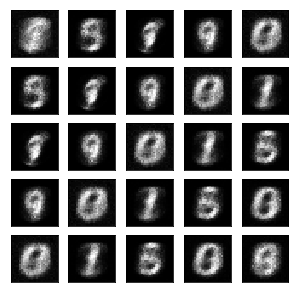

Epoch[2/100], G cost: -3.4199, D cost: -3.8212


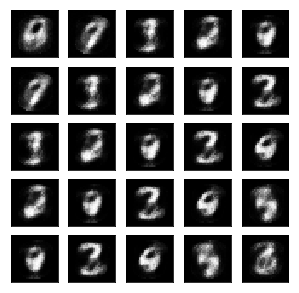

Epoch[3/100], G cost: -4.1770, D cost: -3.1309


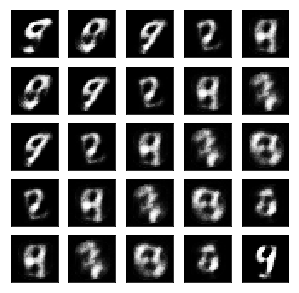

In [ ]:
model = WGANGP(image_size = 784, hidden_dim = 400, z_dim = 256)
if torch.cuda.is_available():
    model = model.cuda()
trainer = Trainer(train_iter, val_iter, test_iter)
model = trainer.train(model = model, num_epochs = 100)